# Fake News Detection

In [1]:
import pandas as pd  #importing data
import numpy as np   #for working with arrays
import matplotlib.pyplot as plt #plotting 
import seaborn as sns #drawing attractive and informative statistical graphics
from sklearn.feature_extraction.text import CountVectorizer #text documents
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline #cross-validated

# Read Datasets

In [2]:
trueData = pd.read_csv("data/True.csv")
fakeData = pd.read_csv("data/Fake.csv")

In [3]:
trueData.shape

(21417, 4)

In [5]:
trueData.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
fakeData.shape

(23481, 4)

In [7]:
fakeData.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Cleaning and Preparing data

In [8]:
# Add flag to track real and fake 
trueData['target'] = 'true'
fakeData['target'] = 'fake'

In [9]:
# Concatenate dataframes
data = pd.concat([fakeData, trueData]).reset_index(drop = True)

In [10]:
data.shape

(44898, 5)

In [11]:
data.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [12]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [13]:
data.shape

(44898, 5)

In [14]:
# Check the data
data.head()

,title,text,subject,date,target
0,MAXINE WATERS: ‘These people trying to ‘discre...,MAXINE GOT A MAKEOVER and is hopping mad about...,left-news,"Jul 22, 2017",fake
1,WATCH: Fox Panel Glorifies This Vile Poverty ...,Fox News recently aired a panel discussion ove...,News,"May 8, 2016",fake
2,INTEL CHAIR Stands Up To Dems Calling For His ...,.@Rep_DevinNunes: I m sure that @TheDemocrats...,Government News,"Mar 27, 2017",fake
3,"In rare bipartisan display, Democrats back Tru...",WASHINGTON (Reuters) - Three top Democratic se...,politicsNews,"August 2, 2017",true
4,No angst over Turkey's air defense deal with R...,"CRAIOVA, Romania (Reuters) - NATO ally Turkey ...",worldnews,"October 10, 2017",true


In [15]:
#Removing the date (we won’t use it for the analysis):
data.drop(["date"],axis=1,inplace=True)

In [16]:
data.head()

,title,text,subject,target
0,MAXINE WATERS: ‘These people trying to ‘discre...,MAXINE GOT A MAKEOVER and is hopping mad about...,left-news,fake
1,WATCH: Fox Panel Glorifies This Vile Poverty ...,Fox News recently aired a panel discussion ove...,News,fake
2,INTEL CHAIR Stands Up To Dems Calling For His ...,.@Rep_DevinNunes: I m sure that @TheDemocrats...,Government News,fake
3,"In rare bipartisan display, Democrats back Tru...",WASHINGTON (Reuters) - Three top Democratic se...,politicsNews,true
4,No angst over Turkey's air defense deal with R...,"CRAIOVA, Romania (Reuters) - NATO ally Turkey ...",worldnews,true


In [17]:
#Removing the title (we will only use the text):
data.drop(["title"],axis=1,inplace=True)

In [18]:
data.head()

,text,subject,target
0,MAXINE GOT A MAKEOVER and is hopping mad about...,left-news,fake
1,Fox News recently aired a panel discussion ove...,News,fake
2,.@Rep_DevinNunes: I m sure that @TheDemocrats...,Government News,fake
3,WASHINGTON (Reuters) - Three top Democratic se...,politicsNews,true
4,"CRAIOVA, Romania (Reuters) - NATO ally Turkey ...",worldnews,true


In [19]:
#Convert the text to lowercase:
data['text'] = data['text'].apply(lambda x: x.lower())

In [20]:
data.head()

,text,subject,target
0,maxine got a makeover and is hopping mad about...,left-news,fake
1,fox news recently aired a panel discussion ove...,News,fake
2,.@rep_devinnunes: i m sure that @thedemocrats...,Government News,fake
3,washington (reuters) - three top democratic se...,politicsNews,true
4,"craiova, romania (reuters) - nato ally turkey ...",worldnews,true


In [21]:
#Remove punctuation:
import string
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
data['text'] = data['text'].apply(punctuation_removal)

In [22]:
data.head()

,text,subject,target
0,maxine got a makeover and is hopping mad about...,left-news,fake
1,fox news recently aired a panel discussion ove...,News,fake
2,repdevinnunes i m sure that thedemocrats do w...,Government News,fake
3,washington reuters three top democratic senat...,politicsNews,true
4,craiova romania reuters nato ally turkey is n...,worldnews,true


In [23]:
# Removing stopwords
import nltk #Natural Language Toolkit
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NAZIRAHMADNAZIR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
data.head()

,text,subject,target
0,maxine got makeover hopping mad speculation ru...,left-news,fake
1,fox news recently aired panel discussion one r...,News,fake
2,repdevinnunes sure thedemocrats want quit know...,Government News,fake
3,washington reuters three top democratic senato...,politicsNews,true
4,craiova romania reuters nato ally turkey seeki...,worldnews,true


# Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


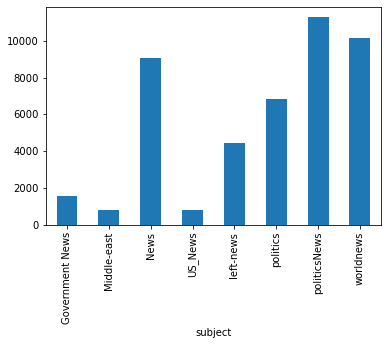

In [25]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


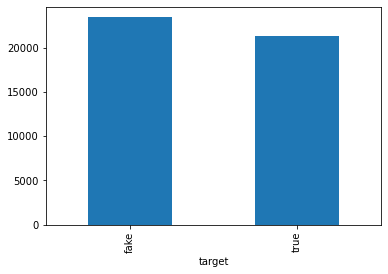

In [26]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

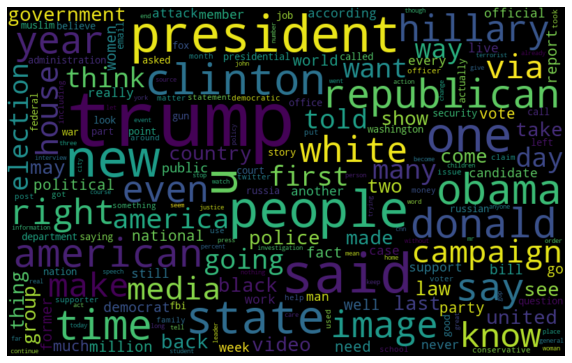

In [27]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

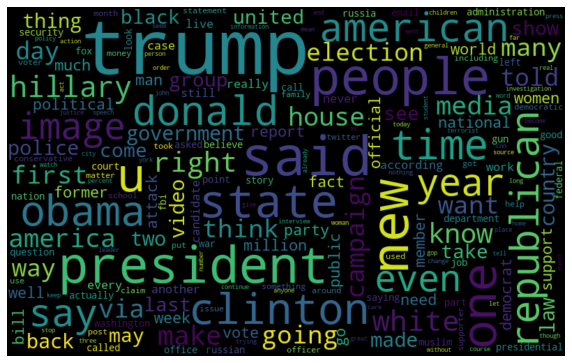

In [28]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
# Most frequent words counter
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

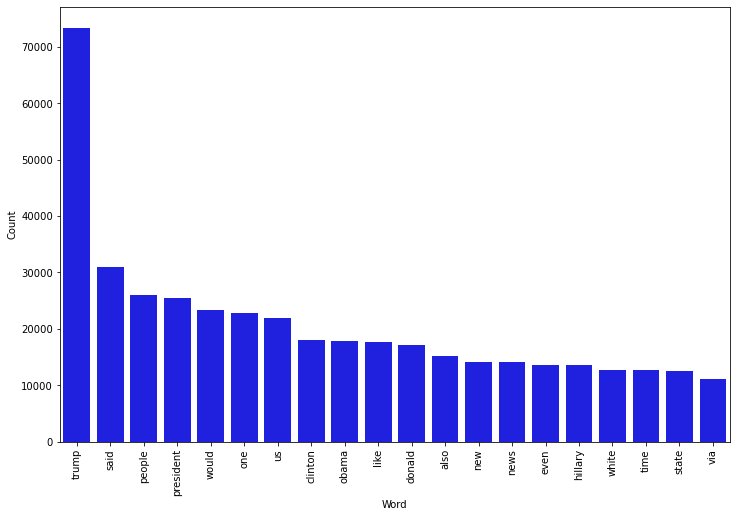

In [30]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

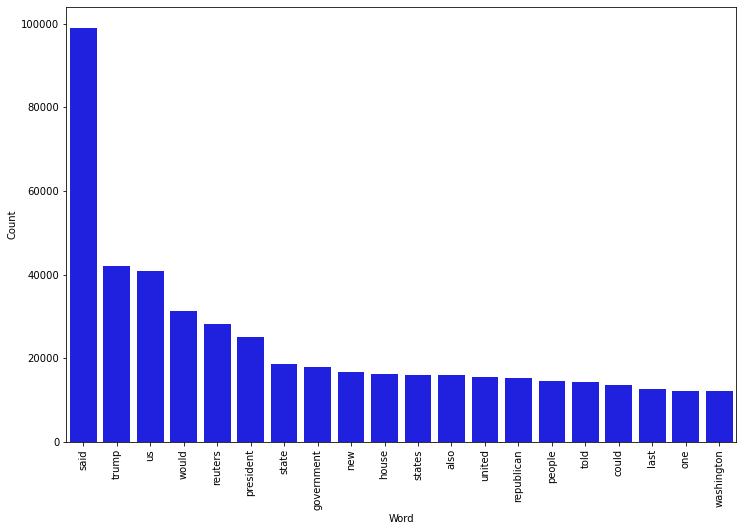

In [31]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

# Modeling

In [32]:
# Function to plot the confusion matrix 
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Preparing the data

In [33]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# Logistic regression

In [34]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.85%


Confusion matrix, without normalization


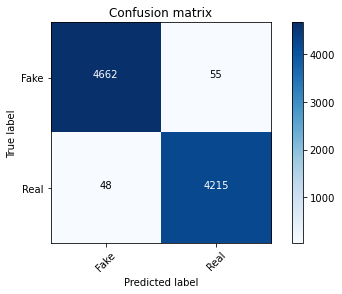

In [35]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Decision Tree Classifier

In [36]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.77%


Confusion matrix, without normalization


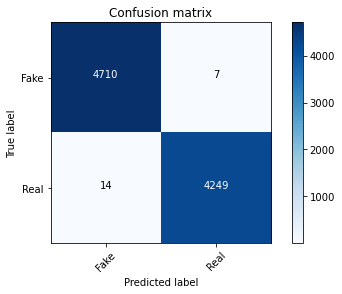

In [37]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.72%


Confusion matrix, without normalization


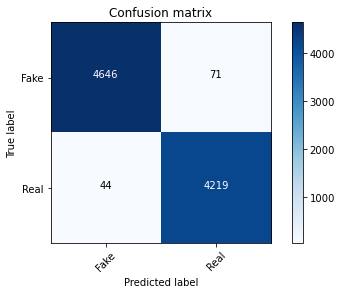

In [39]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Gradient Boosting Classifier


In [100]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', GradientBoostingClassifier())])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Naive_Bayes MultinomialNB

In [42]:
from sklearn.naive_bayes import MultinomialNB
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))


accuracy: 95.09%


Confusion matrix, without normalization


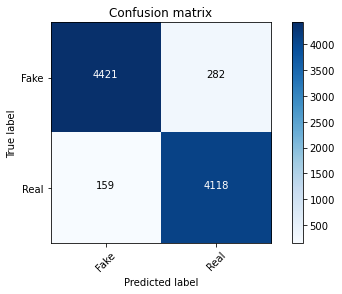

In [43]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Stochastic gradient descent

In [44]:
from sklearn.linear_model import SGDClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', SGDClassifier())])

model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))


accuracy: 99.24%


Confusion matrix, without normalization


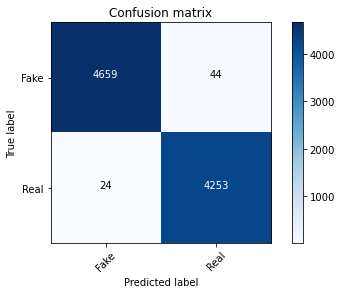

In [45]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])